# Arrow Detection Notebook

In [1]:
!nvidia-smi

Thu Jan 22 13:07:06 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    Off |   00000000:E4:00.0 Off |                    0 |
| N/A   28C    P8             32W /  350W |       0MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# all necessary imports
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from ultralytics import YOLO
from datasets import load_dataset
import random
import math
import yaml

## Download Datasets

roboflow custom arrow pose estimation dataset

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="G02QWpoXIVqxi1SHAzOu")
project = rf.workspace("kevin-cqd3r").project("arrow-detection-gtc2q")
version = project.version(5)
dataset = version.download("yolov8")

# Unzip the downloaded dataset for direct access
# The roboflow.zip file is typically downloaded into the dataset.location directory
# !unzip -q {dataset.location}/roboflow.zip -d {dataset.location}

# Confirm download location and contents (now including unzipped files)
print(f"Dataset downloaded to: {dataset.location}")
print("Contents of the downloaded dataset directory:")
!ls -la {dataset.location}

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to arrow-detection-5 in yolov8:: 100%|██████████| 1216/1216 [00:09<00:00, 131.77it/s]

Dataset downloaded to: /mmfs1/gscratch/krishna/xckevin/arrow-detection/yolo-based/arrow-detection-5
Contents of the downloaded dataset directory:
total 134
drwxr-sr-x 5 xckevin krishna 512 Jan 22 13:36 .
drwxr-sr-x 3 xckevin krishna 512 Jan 22 13:36 ..
-rw-r--r-- 1 xckevin krishna 136 Jan 22 13:36 README.dataset.txt
-rw-r--r-- 1 xckevin krishna 977 Jan 22 13:36 README.roboflow.txt
-rw-r--r-- 1 xckevin krishna 306 Jan 22 13:36 data.yaml
drwxr-sr-x 4 xckevin krishna 512 Jan 22 13:36 test
drwxr-sr-x 4 xckevin krishna 512 Jan 22 13:36 train
drwxr-sr-x 4 xckevin krishna 512 Jan 22 13:36 valid


## Train Model

In [ ]:
model = YOLO("yolo11m-pose.pt")

print("YOLO11 Pose model initialized successfully.")

In [ ]:
results = model.train(data='/arrow-detection-5/data.yaml', epochs=300, imgsz=640, batch=16, patience=15)

# The YOLO trainer automatically saves the best model as 'best.pt' in the run directory.
best_model_path = str(results.save_dir) + '/weights/best.pt'

# Define the path to save the best trained model in Google Drive
model_save_path = 'arrow-detector-v2-medium.pt'

# Copy the best model to the desired location in Google Drive
!cp {best_model_path} {model_save_path}

print(f"Best trained model saved to: {model_save_path}")

## Inference

In [6]:
# Define the path to the saved model in Google Drive
model_path = 'arrow-detector-v2-medium.pt'

# Load the trained model
loaded_model = YOLO(model_path)

print(f"Model loaded successfully from: {model_path}")

Model loaded successfully from: arrow-detector-v2-medium.pt



WARNING ⚠️ NMS time limit 2.050s exceeded
image 1/1 /mmfs1/gscratch/krishna/xckevin/arrow-detection/yolo-based/../pics/pic4.jpeg: 384x640 2 arrows, 754.8ms
Speed: 44.3ms preprocess, 754.8ms inference, 25.9ms postprocess per image at shape (1, 3, 384, 640)


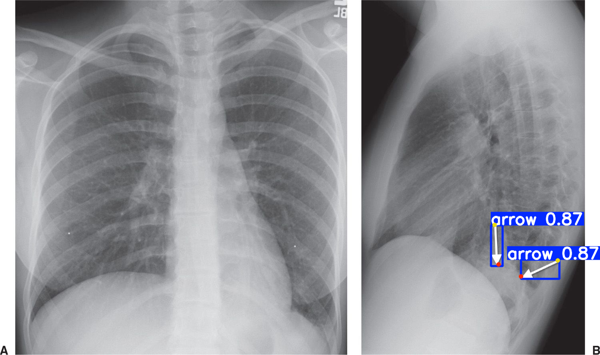

Bounding Boxes:
Arrow 1:  [[1302.35498046875, 649.6018676757812, 1398.4398193359375, 697.5689086914062]]
Arrow 2:  [[1227.0589599609375, 563.7271728515625, 1256.6568603515625, 665.4284057617188]]

Keypoints:
========== Arrow 1 ==========
Tip at [1302.6297607421875, 691.1883544921875]
Tail at [1394.2559814453125, 651.59912109375]
Direction (degrees): -156.63212169722695
========== Arrow 2 ==========
Tip at [1246.0078125, 661.6201171875]
Tail at [1236.7135009765625, 562.3555908203125]
Direction (degrees): -84.65089110947166


In [7]:
def get_arrow_direction(tip_point, tail_point):
    """
    Calculates the direction (angle in radians) of an arrow given its tip and tail points.
    """
    dx = tip_point[0] - tail_point[0]
    dy = (-tip_point[1]) - (-tail_point[1])  # negate bc y-values increase as you go down an image

    angle_radians = math.atan2(dy, dx)
    return math.degrees(angle_radians)

# Define the path to an example image in manual_tests
image_path = '../pics/pic4.jpeg'

# Perform inference on the image
results = loaded_model(image_path)

# Display the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image

    # Resize the image to a constant width for display
    target_width = 600
    original_width, original_height = im.size
    new_height = int((target_width / original_width) * original_height)
    im_resized = im.resize((target_width, new_height))

    display(im_resized)  # display resized image

    # Print bounding boxes and keypoints
    if r.boxes is not None and len(r.boxes) > 0:
        print("Bounding Boxes:")
        for i, box in enumerate(r.boxes):
            print(f"Arrow {i+1}:  {box.xyxy.tolist()}")

    if r.keypoints is not None and len(r.keypoints.xy) > 0:
        print("\nKeypoints:")
        for i, kpts in enumerate(r.keypoints.xy):
            points = kpts.tolist()
            print("="*10 + f" Arrow {i+1} " + "="*10)
            print(f"Tip at {points[0]}")
            print(f"Tail at {points[1]}")
            print(f"Direction (degrees): {get_arrow_direction(points[0], points[1])}")

In [8]:
# Evaluate the model on the test set
metrics = loaded_model.val(data='arrow-detection-5/data.yaml', split='test')

# Print evaluation metrics
print("Evaluation Metrics (Test Set):")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP75: {metrics.box.map75:.4f}")

for i, c in enumerate(metrics.names):
    print(f"  Class '{c}' - Precision: {metrics.box.p[i]:.4f}, Recall: {metrics.box.r[i]:.4f}")

Ultralytics 8.4.7 🚀 Python-3.9.25 torch-2.8.0+cu128 CUDA:0 (NVIDIA L40S, 45458MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 376.2±383.4 MB/s, size: 96.1 KB)
val: Scanning /mmfs1/gscratch/krishna/xckevin/arrow-detection/yolo-based/arrow-detection-5/test/labels... 45 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 45/45 100.8it/s 0.4s.2s
val: New cache created: /mmfs1/gscratch/krishna/xckevin/arrow-detection/yolo-based/arrow-detection-5/test/labels.cache


This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 5.9s/it 17.7s7.5s6
                   all         45        114      0.955      0.921      0.939       0.82       0.94      0.921      0.936      0.888
Speed: 1.4ms preprocess, 73.1ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to /mmfs1/gscratch/krishna/xckevin/arrow-detection/runs/pose/val
Evaluation Metrics (Test Set):
  mAP50-95: 0.8202
  mAP50: 0.9388
  mAP75: 0.9348
  Class '0' - Precision: 0.9545, Recall: 0.9206


In [ ]:
# Define paths to multiple images for batch inference
image_paths_batch = [
    os.path.join(project_path, 'manual-tests/img1.jpg'),
    os.path.join(project_path, 'manual-tests/img2.jpg'),
    os.path.join(project_path, 'manual-tests/img3.png'),
    os.path.join(project_path, 'manual-tests/img5.webp'),
    os.path.join(project_path, 'manual-tests/img6.jpg'),
    os.path.join(project_path, 'manual-tests/imgtest.png'),
    os.path.join(project_path, 'manual-tests/10.jpg'),
    os.path.join(project_path, 'manual-tests/16.jpg'),
    os.path.join(project_path, 'manual-tests/30.png')
]

print(f"Performing batch inference on {len(image_paths_batch)} images...")

# Perform batch inference
batch_results = loaded_model(image_paths_batch)

print("Batch inference complete.")

for i, r in enumerate(batch_results):
    print(f"\n--- Results for Image {i+1} ({image_paths_batch[i]}) ---")
    
    # Load the original image
    original_img = Image.open(image_paths_batch[i])
    img_array = np.array(original_img)
    img_width, img_height = original_img.size
    
    print(f"Original image dimensions: {img_width} x {img_height}")
    
    # Create figure for custom visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img_array)
    
    # Plot bounding boxes and keypoints
    if r.boxes is not None and len(r.boxes) > 0:
        print("Bounding Boxes:")
        for j, box in enumerate(r.boxes):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            print(f"  Arrow {j+1}: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")
            
            # Draw bounding box (cyan rectangle)
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='cyan', facecolor='none')
            ax.add_patch(rect)
    
    if r.keypoints is not None and len(r.keypoints.xy) > 0:
        print("Keypoints:")
        for j, kpts in enumerate(r.keypoints.xy):
            # Get normalized coordinates from YOLO (these are actually pixel coords from the model)
            # But let's explicitly show the conversion process
            kpts_pixel = kpts.cpu().numpy()  # Shape: [2, 2] for tip and tail
            
            # If these were normalized (0-1), we'd convert like this:
            # kpts_normalized = kpts_pixel / np.array([img_width, img_height])
            # kpts_pixel = kpts_normalized * np.array([img_width, img_height])
            
            points = kpts_pixel.tolist()
            print(points)
            
            # Get confidence scores if available
            if r.keypoints.conf is not None and len(r.keypoints.conf) > j:
                conf_scores = r.keypoints.conf[j].cpu().numpy().tolist()
            else:
                conf_scores = [1.0, 1.0]
            
            print("="*10 + f" Arrow {j+1} " + "="*10)
            
            if len(points) >= 2:
                tip = points[0]
                tail = points[1]
                tip_conf = conf_scores[0] if len(conf_scores) > 0 else 0
                tail_conf = conf_scores[1] if len(conf_scores) > 1 else 0
                
                # Manual conversion demonstration:
                # If tip was normalized as [tip_norm_x, tip_norm_y], conversion would be:
                # tip_pixel_x = tip_norm_x * img_width
                # tip_pixel_y = tip_norm_y * img_height
                
                print(f"Tip at ({tip[0]:.1f}, {tip[1]:.1f}) | confidence: {tip_conf:.3f}")
                print(f"Tail at ({tail[0]:.1f}, {tail[1]:.1f}) | confidence: {tail_conf:.3f}")
                
                # For verification, show the reverse conversion (pixel to normalized):
                tip_normalized = [tip[0] / img_width, tip[1] / img_height]
                tail_normalized = [tail[0] / img_width, tail[1] / img_height]
                print(f"  (Normalized: tip={[f'{x:.4f}' for x in tip_normalized]}, tail={[f'{x:.4f}' for x in tail_normalized]})")
                
                # Draw tip (red circle)
                ax.plot(tip[0], tip[1], 'ro', markersize=10, markeredgewidth=2, markeredgecolor='white', label=f'Tip {j+1}' if j == 0 else '')
                # Draw tail (green circle)
                ax.plot(tail[0], tail[1], 'go', markersize=10, markeredgewidth=2, markeredgecolor='white', label=f'Tail {j+1}' if j == 0 else '')
                # Draw line connecting tip and tail (yellow)
                ax.plot([tail[0], tip[0]], [tail[1], tip[1]], 'y-', linewidth=2, alpha=0.7)
                
                if tip_conf > 0.5 and tail_conf > 0.5:
                    direction = get_arrow_direction(tip, tail)
                    print(f"Direction (degrees): {direction:.1f}")
                else:
                    print("Keypoint confidence too low to determine direction reliably")
            else:
                print(f"Error: Expected 2 keypoints, got {len(points)}")
    
    # Configure plot
    ax.set_title(f"Image {i+1}: {len(r.boxes) if r.boxes else 0} arrows detected", fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()